Load Cedar Point Data from AWS Postgres database

In [1]:
import psycopg2
import pandas as pd

def get_db_connection():
    try:
        conn = psycopg2.connect(
            host='cp-ai.cbsscwgeqp5j.us-east-2.rds.amazonaws.com',
            port=5432,
            database='postgres',
            user='postgres',
            password='CedarP0int'
        )
        return conn
    except psycopg2.Error as e:
        print(f"Error connecting to PostgreSQL database: {e}")
        return None

# Example usage:
conn = get_db_connection()
crowd_levels_df_original = pd.read_sql("SELECT * FROM crowd_levels", conn)
conn.close()
crowd_levels_df_original.head()

C:\Users\rober\AppData\Local\Temp\ipykernel_55232\357479555.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  crowd_levels_df_original = pd.read_sql("SELECT * FROM crowd_levels", conn)


,date,crowd_level,year,day_of_week,is_open,forecast_temp,actual_temp,forecast_wind,actual_wind,forecast_rain,...,special_day_mothers_day,special_day_fourth_of_july,special_day_memorial_day,special_day_labor_day,special_day_last_day_of_year,covid_19_day,reload_row,month,cedar_point_week,school_day
0,2018-01-16,1,2018,Tuesday,N,NaN,NaN,NaN,NaN,NaN,...,N,N,N,N,N,N,N,1,NaN,Y
1,2018-01-17,1,2018,Wednesday,N,NaN,NaN,NaN,NaN,NaN,...,N,N,N,N,N,N,N,1,NaN,Y
2,2018-01-18,1,2018,Thursday,N,NaN,NaN,NaN,NaN,NaN,...,N,N,N,N,N,N,N,1,NaN,Y
3,2018-01-19,1,2018,Friday,N,NaN,NaN,NaN,NaN,NaN,...,N,N,N,N,N,N,N,1,NaN,Y
4,2018-02-01,1,2018,Thursday,N,NaN,NaN,NaN,NaN,NaN,...,N,N,N,N,N,N,N,2,NaN,Y


Make a copy of the original dataframe for actual use.  Only include records that are "open" and are not in covid 19 season

In [40]:
crowd_levels_df = crowd_levels_df_original[(crowd_levels_df_original['is_open'] == 'Y') & (crowd_levels_df_original['covid_19_day'] == 'N')].copy()
crowd_levels_df = crowd_levels_df.dropna(subset=['actual_temp', 'actual_rain'])
crowd_levels_df.head()

,date,crowd_level,year,day_of_week,is_open,forecast_temp,actual_temp,forecast_wind,actual_wind,forecast_rain,...,special_day_mothers_day,special_day_fourth_of_july,special_day_memorial_day,special_day_labor_day,special_day_last_day_of_year,covid_19_day,reload_row,month,cedar_point_week,school_day
31,2024-09-22,12,2024,Sunday,Y,24.5,26.3,3.4,3.8,0.00,...,N,N,N,N,N,N,N,9,20.0,Y
32,2024-09-27,66,2024,Friday,Y,21.9,21.7,12.0,8.5,0.24,...,N,N,N,N,N,N,N,9,20.0,Y
33,2024-09-28,88,2024,Saturday,Y,22.0,21.9,4.5,4.0,0.04,...,N,N,N,N,N,N,N,9,21.0,Y
34,2024-09-29,3,2024,Sunday,Y,21.6,21.3,6.9,5.1,0.45,...,N,N,N,N,N,N,N,9,21.0,Y
35,2024-10-04,30,2024,Friday,Y,20.0,20.4,4.7,3.1,0.00,...,N,N,N,N,N,N,N,10,21.0,Y


Convert temperatures to farenheight and remove ndesired columns...  Exclusing special days (minus halloweekends) for now but may add back in since they may show up as anomalies even though they aren't.

Also dropping columns with nulls.  Lots of them have it, especially those where cedar point isn't open.

In [41]:
crowd_levels_df['actual_temp'] = crowd_levels_df['actual_temp'] * 9 / 5 + 32
crowd_levels_df.drop(columns=['forecast_temp','forecast_rain','military_days','light_up_the_point','covid_19_day','reload_row','coaster_mania','fathers_day', 'mothers_day', 'fourth_of_july','boardwalk_nights','memorial_day', 'labor_day','school_season','year','is_open','opening_day','closing_day'], inplace=True)
crowd_levels_df = crowd_levels_df.dropna()


Take desired columns and place them in my X information for use in the model.  convert flags to binary 1/0 values.  Also convert day of week to number.

In [43]:
# excluding holidays for now

X_raw = crowd_levels_df.copy().dropna()
flag_columns = ['hallowweekend']
for flag_column in flag_columns:
    X_raw[flag_column] = (X_raw[flag_column] == 'Y').astype('int')

import numpy as np
day_to_num_mapping = {'Monday': 0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}
X_raw['day_of_week_num'] = X_raw['day_of_week'].map(day_to_num_mapping)
X_raw = X_raw.drop(columns=['day_of_week_num','day_of_week','date'])
X_raw.head()

,crowd_level,actual_temp,forecast_wind,actual_wind,actual_rain,special_day_halloweekends,month,cedar_point_week
31,12,79.34,3.4,3.8,0.03,1,9,20.0
32,66,71.06,12.0,8.5,0.08,1,9,20.0
33,88,71.42,4.5,4.0,0.23,1,9,21.0
34,3,70.34,6.9,5.1,0.09,1,9,21.0
35,30,68.72,4.7,3.1,0.00,1,10,21.0


Create and train model.

In [44]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(X_raw)  # X_raw is your feature dataframe or numpy array


IsolationForest(contamination=0.05, random_state=42)

Evaluate results and view.  Also add back date.

In [45]:
y_pred = clf.predict(X_raw)
crowd_levels_df['anomaly'] = (y_pred == -1).astype(int)

Inspect anomalies

In [46]:
crowd_levels_df[crowd_levels_df['anomaly'] == 1].sort_values('crowd_level').head(50)

,date,crowd_level,day_of_week,actual_temp,forecast_wind,actual_wind,actual_rain,special_day_halloweekends,month,cedar_point_week,anomaly
2697,2022-09-22,1,Thursday,61.16,9.7,8.3,0.00,Y,9,19.0,1
2179,2021-10-29,1,Friday,55.94,10.6,8.1,0.91,Y,10,24.0,1
2653,2025-05-21,2,Wednesday,59.18,5.7,2.3,1.51,N,5,2.0,1
56,2021-09-01,4,Wednesday,74.30,9.4,9.1,0.01,N,9,15.0,1
1519,2025-05-04,4,Sunday,49.82,10.1,6.7,0.88,N,5,0.0,1
1034,2024-10-24,5,Thursday,47.84,2.5,1.6,0.00,Y,10,24.0,1
961,2023-10-05,7,Thursday,63.50,5.7,4.1,0.81,Y,10,21.0,1
2700,2022-09-25,10,Sunday,64.58,8.2,7.3,0.83,Y,9,20.0,1
1521,2025-05-08,10,Thursday,49.10,6.4,5.9,0.03,N,5,0.0,1
2065,2024-11-01,12,Friday,50.72,5.1,4.4,0.00,N,11,25.0,1


Plot anomalies

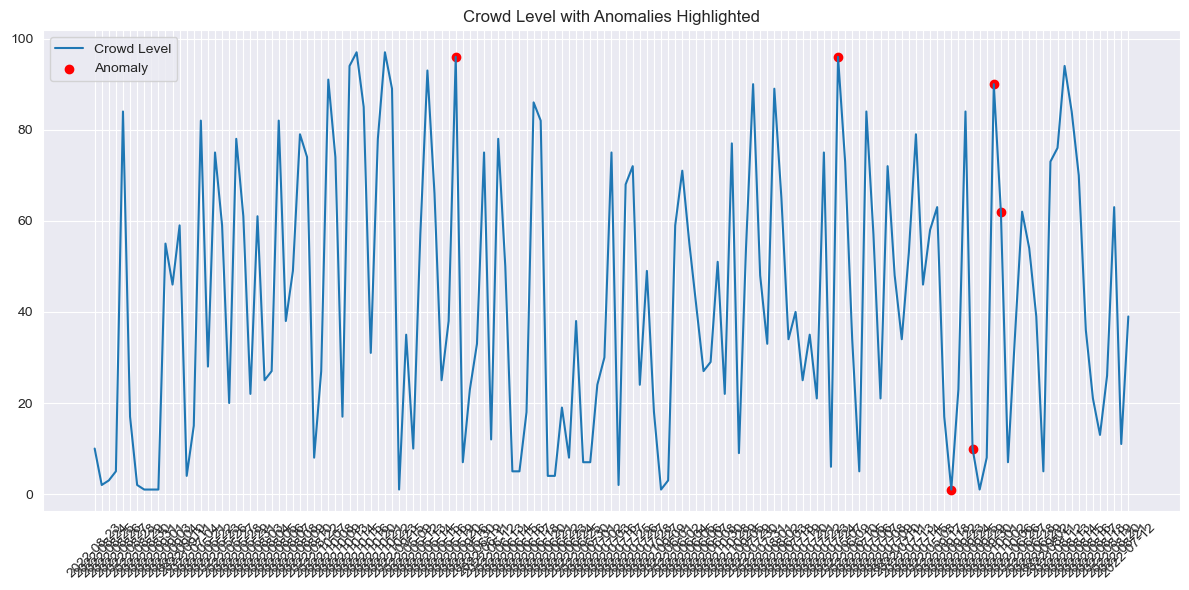

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Define date bounds
start = '2022-01-01'
end   = '2022-12-31'

# Plot main line (filtered)
plt.plot(
    crowd_levels_df.loc[
        (crowd_levels_df['date'] >= start) & (crowd_levels_df['date'] <= end), 'date'
    ],
    crowd_levels_df.loc[
        (crowd_levels_df['date'] >= start) & (crowd_levels_df['date'] <= end), 'crowd_level'
    ],
    label='Crowd Level'
)

anomaly_filter = (
    (crowd_levels_df['date'] >= start) &
    (crowd_levels_df['date'] <= end) &
    (crowd_levels_df['anomaly'] == 1)
)
plt.scatter(
    crowd_levels_df.loc[anomaly_filter, 'date'],
    crowd_levels_df.loc[anomaly_filter, 'crowd_level'],
    color='red',
    label='Anomaly'
)
plt.legend()
plt.title("Crowd Level with Anomalies Highlighted")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
